MOUNTING DRIVE

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install unrar


EXTRACTING DATASETS FROM DRIVE

In [2]:
!unrar x gdrive/My\ Drive/FER-7-CNN/FERtrain.rar


Streaming output truncated to the last 5000 lines.
Extracting  FERtrain/sad/Training_65275626.jpg                            82%  OK 
Extracting  FERtrain/sad/Training_6529266.jpg                             82%  OK 
Extracting  FERtrain/sad/Training_65329617.jpg                            82%  OK 
Extracting  FERtrain/sad/Training_65338712.jpg                            82%  OK 
Extracting  FERtrain/sad/Training_65338797.jpg                            82%  OK 
Extracting  FERtrain/sad/Training_65387162.jpg                            82%  OK 
Extracting  FERtrain/sad/Training_65404494.jpg                            82%  OK 
Extracting  FERtrain/sad/Training_65426218.jpg                            82%  OK 
Extracting  FERtrain/sad/Training_65430136.jpg                            82%  OK 
Extracting  FERtrain/sad/Training_65437377.jpg                            82%  OK 
Extracting  FERtrain/sad/Trai

In [3]:
!unrar x gdrive/My\ Drive/FER-7-CNN/FERtest.rar

Streaming output truncated to the last 5000 lines.
Extracting  FERtest/happy/PrivateTest_22154496.jpg                        30%  OK 
Extracting  FERtest/happy/PrivateTest_2260082.jpg                         30%  OK 
Extracting  FERtest/happy/PrivateTest_22689070.jpg                        30%  OK 
Extracting  FERtest/happy/PrivateTest_22929697.jpg                        30%  OK 
Extracting  FERtest/happy/PrivateTest_22938435.jpg                        30%  OK 
Extracting  FERtest/happy/PrivateTest_22979298.jpg                        30%  OK 
Extracting  FERtest/happy/PrivateTest_2309763.jpg                         30%  OK 
Extracting  FERtest/happy/PrivateTest_23250597.jpg                        30%  OK 
Extracting  FERtest/happy/PrivateTest_23282756.jpg                        30%  OK 
Extracting  FERtest/happy/PrivateTest_23344981.jpg                        30%  OK 
Extracting  FERtest/happy/Pri

IMPORTING LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras import optimizers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras.callbacks import ReduceLROnPlateau

EXPLORING DATASETS

In [ ]:
train_dir = "/content/FERtrain/"
test_dir ="/content/FERtest/"
row , col = 48 , 48
classes = 7


def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)


        sad  neutral  fear  surprise  angry  happy  disgust
train  4830     4965  4097      3171   3995   7215      436
       sad  neutral  fear  surprise  angry  happy  disgust
test  1247     1233  1024       831    958   1774      111


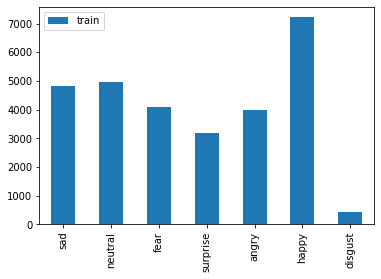

In [ ]:
train_count.transpose().plot(kind='bar')

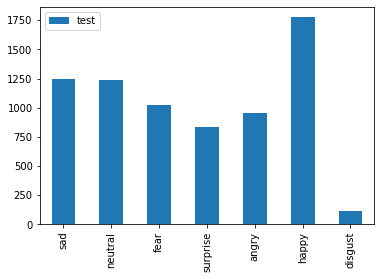

In [ ]:
test_count.transpose().plot(kind='bar')

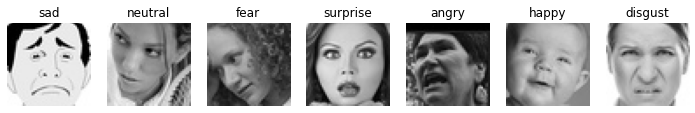

In [ ]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[5]))
    plt.subplot(1,8,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

TRAIN TEST AND VALIDATION DATASETS

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='training')
validation_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='validation')


test_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# labels 
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

MODEL ARCHITECTURE

In [ ]:
weight_decay = 1e-4

num_classes = 7



model = tf.keras.models.Sequential()
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(48,48,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation="linear"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.45))
model.add(Dense(256, activation="linear"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.45))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer = Adam(0.0001) , metrics=['accuracy'])

    
model.summary() 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 activation_60 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_60 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_49 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 activation_61 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_61 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                     

MODEL TRAINING

In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint(
                    filepath='model.weights.best.hdf5',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")
                ]
                

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

history = model.fit(x=training_set,
                 validation_data=validation_set,
                 epochs=40,
                 callbacks=[checkpointer],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/40
358/358 [==============================] - ETA: 0s - loss: 2.3506 - accuracy: 0.2227
Epoch 1: val_accuracy did not improve from 0.63975
358/358 [==============================] - 24s 62ms/step - loss: 2.3506 - accuracy: 0.2227 - val_loss: 2.1061 - val_accuracy: 0.1835
Epoch 2/40
358/358 [==============================] - ETA: 0s - loss: 2.0961 - accuracy: 0.2874
Epoch 2: val_accuracy did not improve from 0.63975
358/358 [==============================] - 23s 64ms/step - loss: 2.0961 - accuracy: 0.2874 - val_loss: 1.8381 - val_accuracy: 0.3673
Epoch 3/40
358/358 [==============================] - ETA: 0s - loss: 1.9082 - accuracy: 0.3469
Epoch 3: val_accuracy did not improve from 0.63975
358/358 [==============================] - 22s 62ms/step - loss: 1.9082 - accuracy: 0.3469 - val_loss: 1.6493 - val_accuracy: 0.4338
Epoch 4/40
358/358 [==============================] - ETA: 0s - loss: 1.7740 - accuracy: 0.3881
Epoch 4: val_accuracy did not improve from 0.63975
358/358 [====

MODEL PERFORMANCE

PLOTTING TRAINING LOSS/ VAL-LOSS VS EPOCHS

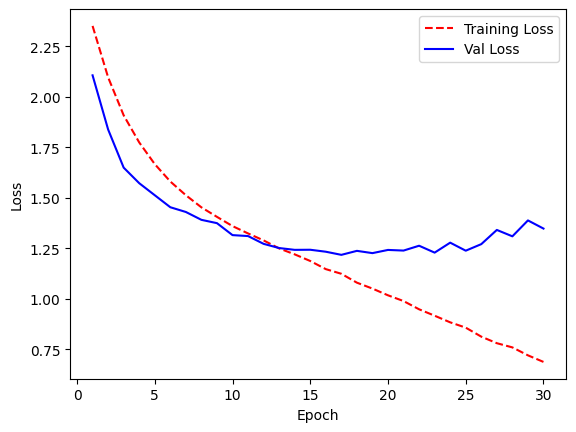

In [ ]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

PLOTTING ACCURACY/VAL_ACCURACY VS EPOCHS

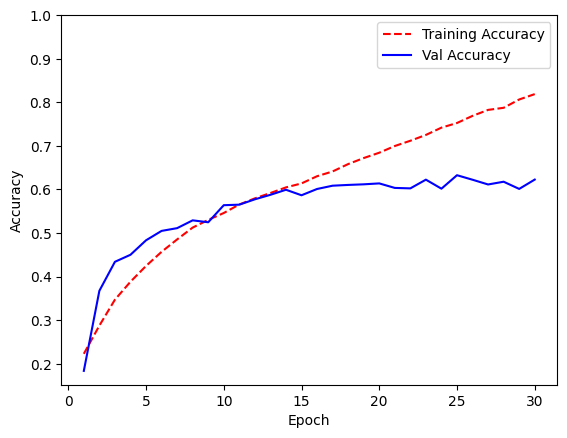

In [ ]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)
plt.show()

SAVING MODEL

In [ ]:
model.save("fer7_model.h5")

TEST ACCURACY

In [ ]:
print(f"Test accuracy = {model.evaluate(test_set ,batch_size=test_set.batch_size,steps=test_set.n // test_set.batch_size)[1]*100}%")

112/112 [==============================] - 3s 22ms/step - loss: 1.2351 - accuracy: 0.6274
Test accuracy = 62.73716688156128%


PLOTTING PREDICTIONS

In [ ]:
# next function assigns one batch to variables, i.e x_test,y_test will have 64 images
x_test,y_test = next(test_set)
predict = model.predict(x_test)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

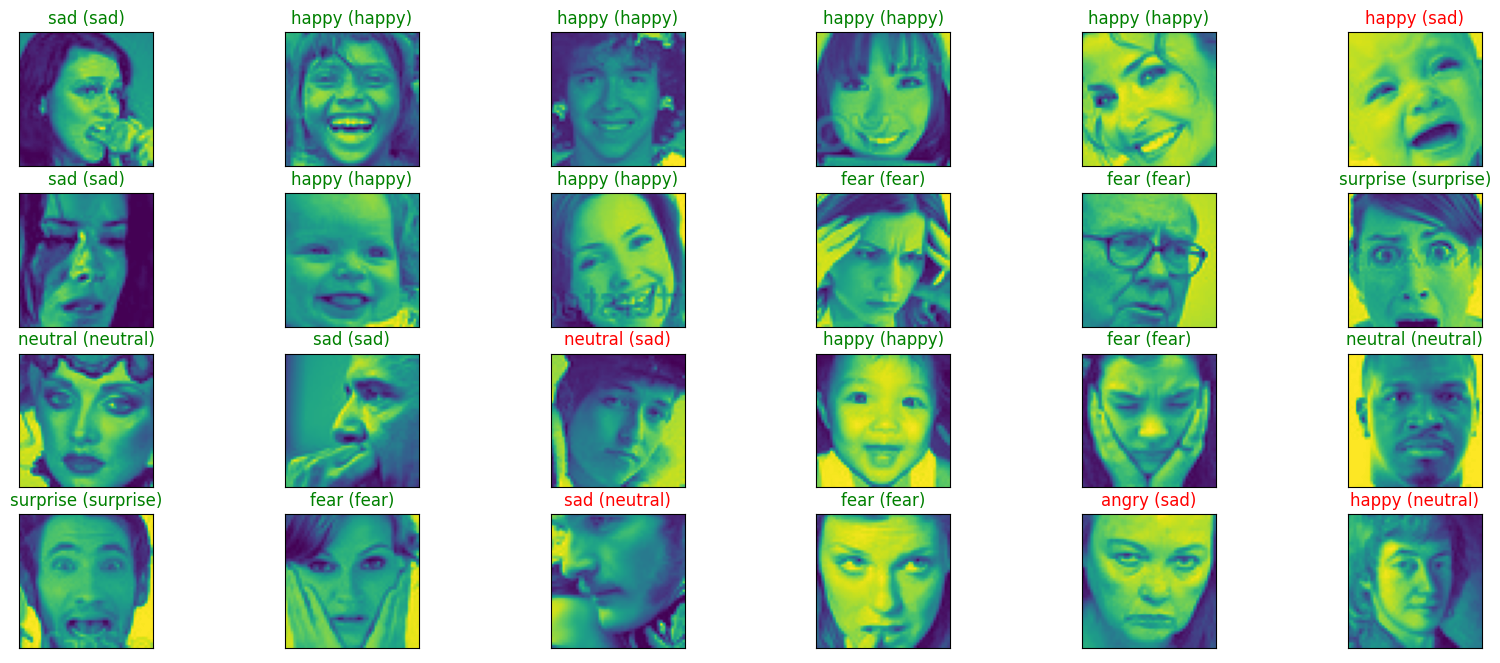

In [ ]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = class_labels[(np.argmax(predict[index]))]
    true_index = class_labels[(np.argmax(y_test[index]))]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))